In [4]:
%matplotlib inline
#%reset
import galsim
import matplotlib.pyplot as plt
import numpy as np
from chrom_objects import *
import short_cut_fns as sc

In [2]:
# pixel scale of intrpolated image not saved at previous checkpoint

In [6]:
eu_filter=galsim.Bandpass('simple_filter.txt')#.thin(rel_err=1e-6)   
blue_SED = galsim.SED('simple_blue_SED.txt', wave_type='nm',flux_type='fphotons').withFlux(100,eu_filter)
red_SED = galsim.SED('simple_red_SED.txt', wave_type='nm',flux_type='fphotons').withFlux(100,eu_filter)

In [7]:
def ring_test_moments_test(galaxy,psf,psf_im,im_param,return_im=False):
    #has a print_index to plot ring test images
    gal_im_tot={}
    g_i=np.array([[0.01,0.01],[0.015,0.015]])
    phi=[0,90,30,120,60,150]
    g_obs=[[],[]]
    rt_e=0.1
    for g in g_i:
        sum=[0,0]
        n=0
        for rt_phi in phi:
            rt_shr=galsim.Shear(e=rt_e,beta=rt_phi*galsim.degrees)
            galaxy1=galaxy.shear(e1=rt_shr.e1,e2=rt_shr.e2)
            galaxy1=galaxy1.shear(g1=g[0],g2=g[1])
            gal_im=im_chr_test(galaxy1,psf,im_param)
            gal_im_tot[n]=gal_im.array
            result  = galsim.hsm.EstimateShear(gal_im,psf_im,shear_est='REGAUSS',strict=True)#,weight=weight_fn)
            a=galsim.Shear(e1=result.corrected_e1,e2=result.corrected_e2)
            sum[0]+=a.g1
            sum[1]+=a.g2
            n+=1
        g_obs[0].append(sum[0]/n)
        g_obs[1].append(sum[1]/n)
    regression = np.polyfit([g_i[0][0],g_i[1][0]], g_obs[0], 1)
    m1=(1-regression[0])
    c1=(regression[1])
    regression = np.polyfit([g_i[0][1],g_i[1][1]], g_obs[1], 1)
    m2=(1-regression[0])
    c2=(regression[1])
    if (return_im==True):
        return [m1,m2],[c1,c2],g_obs,gal_im_tot
    else :
        return [m1,m2],[c1,c2],g_obs

def im_chr_test(gal,psf,im_param):
    conv = galsim.Convolve([gal, psf])
    gal_im=conv.drawImage(im_param.filt,image=im_param.draw_image())
    return gal_im

In [8]:
I_size=256         # Image size
pixel_scale = 0.05      #pixel scale
w1,w2,w3=0.102,0.15,0.054
base_wavelength=800.
B1_re_b=0.17
B1_re_d=1.2
#B1_n_b=4.#1.5
#B1_n_d=1.
gal_flux=1e5
alpha=1
n_fail_cg,n_fail_e=0,0
#t_b_flux=0.0



In [10]:
class simple_image:
    def __init__(self,
                 I_size=[128,128], 
                 pixel_scale=None,
                 method='auto',
                 T_fn=None
                ):
        """Class to store parametrs used to draw images
        I_size     : Size of image; default=[128,128]
        pixel_scale: Scale to draw the image, in arcsec/pixel;default lets galsim pick scale depending on Nyquist scale
        method: """
        self.size=I_size
        self.scale=pixel_scale
        self.method=method
        self.filt=T_fn
    def draw_image(self):
        return galsim.ImageF(self.size[0],self.size[1],scale=self.scale)
         
    

In [11]:
sigma_800=w2

In [12]:
def measure_shear(ratio,redshifts,shape_only=False,print_difim_rt=False,plot_SED=False,rt_return_images=False):
    data,x_tot,bulge_y,disc_y,comp_y,fil_y={},{},{},{},{},{}
    t_b_flux=ratio
    gals_cg,gals_v,gals_s,psfs={},{},{},{}
    mz_cg,mz_e_v,mz_e_s=[[],[]],[[],[]],[[],[]]    
    cz_cg,cz_e_v,cz_e_s=[[],[]],[[],[]],[[],[]]
    mz_cg_e_v,mz_cg_e_s=[[],[]],[[],[]]     
    for redshift in redshifts:
        bulge_y[redshift],disc_y[redshift],comp_y[redshift],fil_y[redshift]=[],[],[],[]
        b_SED=red_SED.atRedshift(redshift)#.withFlux(bandpass=eu_filter,target_flux=1)
        d_SED=blue_SED.atRedshift(redshift)#.withFlux(bandpass=eu_filter,target_flux=1)
        c_SED=(t_b_flux*b_SED +((1-t_b_flux)*d_SED))
        x[redshift]=np.linspace(200,1000,40)
        for i in x['redshift']:
            bulge_y[redshift].append(b_SED(i))
            disc_y[redshift].append(d_SED(i))
            comp_y[redshift].append(c_SED(i))
            fil_y[redshift].append(eu_filter(i)*1.2)
       
        # PSF
        image_param=simple_image([I_size,I_size],pixel_scale,T_fn=eu_filter)
        psf=psf_chr(base_wavelength,alpha,sigma=sigma_800)
        star = galsim.Gaussian(fwhm=1.0e-8,flux=1)
        star1=(star*c_SED)
        psf_im=im_chr_test(star1,psf,image_param)
        psfs[redshift]=((psf_im.array)[I_size/2])/max((psf_im.array)[I_size/2])
        conv1=galsim.Convolve([psf,star1])
        image_param2=simple_image([I_size*4,I_size*4],pixel_scale/4,method='no_pixel',T_fn=eu_filter)
        psf_im_np=conv1.drawImage(eu_filter,method=image_param2.method,image=image_param2.draw_image())
        
        #Galaxy  with CG  _cg
        galaxy_cg=gal_chr_gaus(B1_re_b,B1_re_d,gal_flux,t_b_flux,b_SED=b_SED,d_SED=d_SED)
        gal_cg_im=im_chr_test(galaxy_cg,star,image_param)
        gals_cg[redshift]=np.array(gal_cg_im.array)[I_size/2]/max((gal_cg_im.array)[I_size/2])
        
        #Galxy without CG: effective _e Voigt
        galaxy_e_v= gal_chr_gaus(B1_re_b,B1_re_d,gal_flux,t_b_flux,c_SED=c_SED)
        gal_e_im_v=im_chr_test(galaxy_e_v,star,image_param)
        gals_v[redshift]=np.array(gal_e_im_v.array)[I_size/2]/max((gal_e_im_v.array)[I_size/2])
        
        #Galxy without CG: effective _e   ### Deconvolved galaxy Semboloni
        psf2=galsim.InterpolatedImage(psf_im_np)    
        inv_psf = galsim.Deconvolve(psf2)
        conv=galsim.Convolve([galaxy_cg,psf])
        deconv_gal = galsim.Convolve(inv_psf, conv)    
        image_param3=simple_image([I_size*4,I_size*4],pixel_scale/4,method='no_pixel',T_fn=eu_filter)
        deconv_img=deconv_gal.drawImage(eu_filter,image=image_param2.draw_image(),method=image_param3.method)
        galaxy_e_s=galsim.InterpolatedImage(deconv_img)*c_SED
        gal_e_im_s=im_chr_test(galaxy_e_s,star,image_param)
        gals_s[redshift]=np.array(gal_e_im_s.array)[I_size/2]/max((gal_e_im_s.array)[I_size/2])#/gal_e_im_s.array.sum()
        
        if (shape_only==False):
            if(rt_return_images==False): 
                m_cg,c_cg,g_cg    =  ring_test_moments_test(galaxy_cg, psf,psf_im,image_param)
                m_e_v,c_e_v,g_e_v =  ring_test_moments_test(galaxy_e_v,psf,psf_im,image_param)
                m_e_s,c_e_s,g_e_s =  ring_test_moments_test(galaxy_e_s,psf,psf_im,image_param)
            #print(g_cg)
            else:
                m_cg,c_cg,g_cg,cg_tot   = ring_test_moments_test(galaxy_cg, psf,psf_im,image_param,return_im=rt_return_images)
                m_e_v,c_e_v,g_e_v,v_tot = ring_test_moments_test(galaxy_e_v,psf,psf_im,image_param,return_im=rt_return_images)
                m_e_s,c_e_s,g_e_s,s_tot = ring_test_moments_test(galaxy_e_s,psf,psf_im,image_param,return_im=rt_return_images)
                plt.figure(figsize=[12,24])
                plt.subplots_adjust(wspace = 0.2)
                plt.subplots_adjust(hspace = 0.4)
                for i in range(6):
                    plt.subplot(12,3,i+1)
                    plt.imshow(np.array(cg_tot[i])-np.array(v_tot[i]))
                    plt.title('Voigt')
                    plt.colorbar()
                    plt.subplot(12,3,i+7)
                    plt.imshow(np.array(cg_tot[i])-np.array(s_tot[i]))
                    plt.title('Semboloni')
                    plt.colorbar()
    
            components=[0,1] 
            for com in components:
                mz_cg[com].append(m_cg[com])
                mz_e_v[com].append(m_e_v[com])   
                mz_e_s[com].append(m_e_s[com])
                cz_cg[com].append(c_cg[com])
                cz_e_v[com].append(c_e_v[com])
                cz_e_s[com].append(c_e_s[com]) 
                mz_cg_e_v[com].append((np.array(g_cg[com][0])-np.array(g_cg[com][1]))/(np.array(g_e_v[com][0])-np.array(g_e_v[com][1]))-1)
                mz_cg_e_s[com].append((np.array(g_cg[com][0])-np.array(g_cg[com][1]))/(np.array(g_e_s[com][0])-np.array(g_e_s[com][1]))-1)
                
    if (plot_SED==True):
        data['x'],data['bulge'],data['disk'],data['comp'],data['filt']=x,bulge_y,disc_y,comp_y,fil_y
        names=['x','bulge','disk','comp','filt']
        titles=['Redshift={0};n_b={1}'.format(k,t_b_flux) for k in redshifts]
        colors=['b','r','g','--k']
        sc.simple_sublot(data,names,redshifts,titles,n_columns=3,legends=names[1:],colors=colors,figsize=[14,12],space=[0.6,0.6])
    if (shape_only==True):
        return gals_cg,gals_v,gals_s,psfs
    return mz_cg,mz_e_v,mz_e_s,cz_cg,cz_e_v,cz_e_s,mz_cg_e_v,mz_cg_e_s

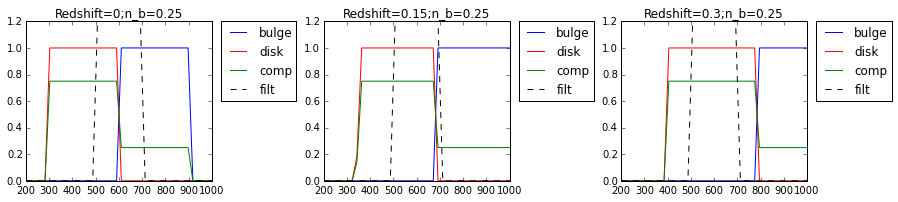

In [150]:
redshifts=[0,0.15,0.3]
gals_cg,gals_v,gals_s,psfs=measure_shear(0.25,redshifts,plot_SED=True,shape_only=True)

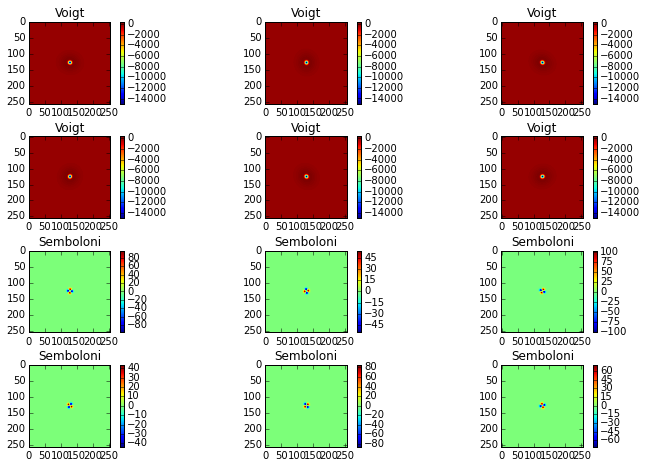

In [151]:
redshifts=[0.05]#np.linspace(0,0.3,5)
ratio=0.25
m1,m2,m3,c1,c2,c3,m12,m13=measure_shear(ratio,redshifts,rt_return_images=True)

In [154]:
redshifts=np.linspace(0,0.3,10)
ratio=0.0
m1,m2,m3,c1,c2,c3,m12,m13=measure_shear(ratio,redshifts)

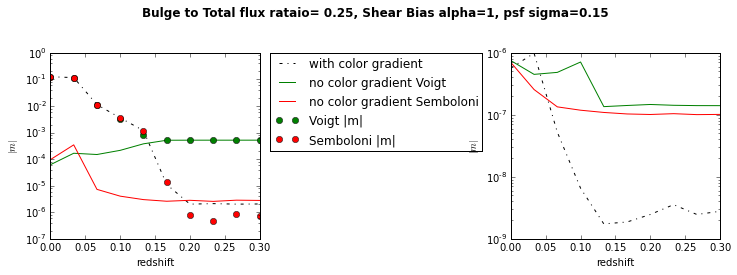

In [153]:
indx=1
plt.figure(1,figsize=[12,8])
plt.subplots_adjust(wspace = 1.2)
plt.subplots_adjust(hspace = 0.4)
plt.subplot(2,2,1)
plt.semilogy(redshifts,np.abs(m1[indx]),'-.k',label='with color gradient')
plt.semilogy(redshifts,np.abs(m2[indx]),'g',label='no color gradient Voigt')
plt.semilogy(redshifts,np.abs(m3[indx]),'r',label='no color gradient Semboloni')
plt.semilogy(redshifts,np.abs(m12[indx]),'og',label='Voigt |m|')
plt.semilogy(redshifts,np.abs(m13[indx]),'or',label='Semboloni |m|')

plt.xlabel('redshift')
plt.ylabel('$|m|$')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.subplot(2,2,2)
plt.semilogy(redshifts,np.abs(c1[indx]),'-.k')
plt.semilogy(redshifts,np.abs(c2[indx]),'g')
plt.semilogy(redshifts,np.abs(c3[indx]),'r')
plt.xlabel('redshift')
plt.ylabel('$|m|$')
plt.suptitle('Bulge to Total flux rataio= {0}, Shear Bias alpha={1}, psf sigma={2}'.format(ratio,alpha,sigma_800),fontsize=12,fontweight='bold')

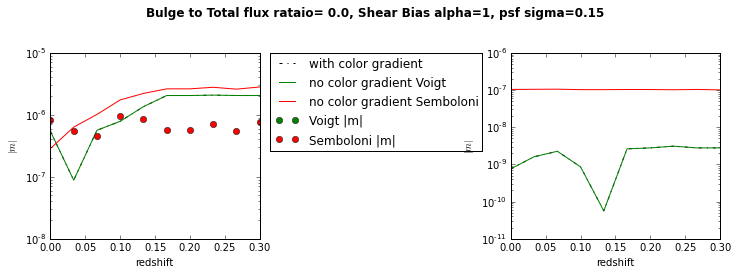

In [155]:
indx=1
plt.figure(1,figsize=[12,8])
plt.subplots_adjust(wspace = 1.2)
plt.subplots_adjust(hspace = 0.4)
plt.subplot(2,2,1)
plt.semilogy(redshifts,np.abs(m1[indx]),'-.k',label='with color gradient')
plt.semilogy(redshifts,np.abs(m2[indx]),'g',label='no color gradient Voigt')
plt.semilogy(redshifts,np.abs(m3[indx]),'r',label='no color gradient Semboloni')
plt.semilogy(redshifts,np.abs(m12[indx]),'og',label='Voigt |m|')
plt.semilogy(redshifts,np.abs(m13[indx]),'or',label='Semboloni |m|')

plt.xlabel('redshift')
plt.ylabel('$|m|$')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.subplot(2,2,2)
plt.semilogy(redshifts,np.abs(c1[indx]),'-.k')
plt.semilogy(redshifts,np.abs(c2[indx]),'g')
plt.semilogy(redshifts,np.abs(c3[indx]),'r')
plt.xlabel('redshift')
plt.ylabel('$|m|$')
plt.suptitle('Bulge to Total flux rataio= {0}, Shear Bias alpha={1}, psf sigma={2}'.format(ratio,alpha,sigma_800),fontsize=12,fontweight='bold')

In [163]:
gals_cg_b,gals_v_b,gals_s_b,psfs_b={},{},{},{}
redshifts=[0,0.07,0.2]
ratios=[0.0,0.15,0.35]
for ratio in ratios:
    gals_cg_b[ratio],gals_v_b[ratio],gals_s_b[ratio],psfs_b[ratio]=measure_shear(ratio,redshifts,shape_only=True)

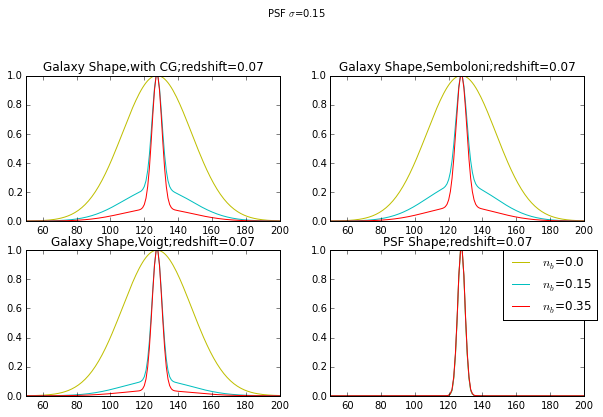

In [166]:
i=1
plt.figure(figsize=[10,12])
plt.subplot(4,2,1)
plt.plot(gals_cg_b[ratios[0]][redshifts[i]],'y',label='n_b=0.0')
plt.plot(gals_cg_b[ratios[1]][redshifts[i]],'c',label='n_b=0.15')
plt.plot(gals_cg_b[ratios[2]][redshifts[i]],'r',label='n_b=0.35')
plt.ylim([0,1])
plt.xlim([50,200])
plt.title('Galaxy Shape,with CG;redshift={0}'.format(redshifts[i]))
plt.subplot(4,2,2)
plt.plot(gals_s_b[ratios[0]][redshifts[i]],'y',label='n_b=0.0')
plt.plot(gals_s_b[ratios[1]][redshifts[i]],'c',label='n_b=0.15')
plt.plot(gals_s_b[ratios[2]][redshifts[i]],'r',label='n_b=0.35')
plt.xlim([50,200])
plt.ylim([0,1])
plt.title('Galaxy Shape,Semboloni;redshift={0}'.format(redshifts[i]))
plt.subplot(4,2,3)
plt.plot(gals_v_b[ratios[0]][redshifts[i]],'y',label='n_b=0.0')
plt.plot(gals_v_b[ratios[1]][redshifts[i]],'c',label='n_b=0.15')
plt.plot(gals_v_b[ratios[2]][redshifts[i]],'r',label='n_b=0.35')
plt.xlim([50,200])
plt.ylim([0,1])
plt.title('Galaxy Shape,Voigt;redshift={0}'.format(redshifts[i]))
plt.subplot(4,2,4)
plt.plot(psfs_b[ratios[0]][redshifts[i]],'y',label='$n_b$={}'.format(ratios[0]))
plt.plot(psfs_b[ratios[1]][redshifts[i]],'c',label='$n_b$={}'.format(ratios[1]))
plt.plot(psfs_b[ratios[2]][redshifts[i]],'r',label='$n_b$={}'.format(ratios[2]))
plt.xlim([50,200])
plt.ylim([0,1])
plt.legend(bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.)
plt.title('PSF Shape;redshift={0}'.format(redshifts[i]))
plt.legend(bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.)
plt.suptitle('PSF $\sigma$={0}'.format(sigma_800))
#plt.savefig('shape_ratio.png',bbox_inches='tight')

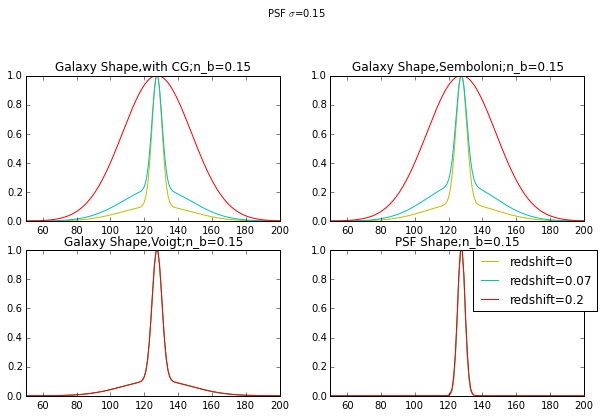

In [167]:
i=1
plt.figure(figsize=[10,12])
plt.subplot(4,2,1)
plt.plot(gals_cg_b[ratios[i]][redshifts[0]],'y',label='z=0.0')
plt.plot(gals_cg_b[ratios[i]][redshifts[1]],'c',label='z=0.15')
plt.plot(gals_cg_b[ratios[i]][redshifts[2]],'r',label='z=0.35')
plt.xlim([50,200])
plt.ylim([0,1])
plt.title('Galaxy Shape,with CG;n_b={0}'.format(ratios[i]))
plt.subplot(4,2,2)
plt.plot(gals_s_b[ratios[i]][redshifts[0]],'y',label='z=0.0')
plt.plot(gals_s_b[ratios[i]][redshifts[1]],'c',label='z=0.15')
plt.plot(gals_s_b[ratios[i]][redshifts[2]],'r',label='z=0.35')
plt.xlim([50,200])
plt.ylim([0,1])
plt.title('Galaxy Shape,Semboloni;n_b={0}'.format(ratios[i]))
plt.subplot(4,2,3)
plt.plot(gals_v_b[ratios[i]][redshifts[0]],'y',label='z=redshifts[0]')
plt.plot(gals_v_b[ratios[i]][redshifts[1]],'c',label='z=0.15')
plt.plot(gals_v_b[ratios[i]][redshifts[2]],'r',label='z=0.35')
plt.xlim([50,200])
plt.ylim([0,1])
plt.title('Galaxy Shape,Voigt;n_b={0}'.format(ratios[i]))
plt.subplot(4,2,4)
plt.plot(psfs_b[ratios[i]][redshifts[0]],'y',label='redshift={}'.format(redshifts[0]))
plt.plot(psfs_b[ratios[i]][redshifts[1]],'c',label='redshift={}'.format(redshifts[1]))
plt.plot(psfs_b[ratios[i]][redshifts[2]],'r',label='redshift={}'.format(redshifts[2]))
plt.xlim([50,200])
plt.ylim([0,1])
plt.legend(bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.)
plt.title('PSF Shape;n_b={0}'.format(ratios[i]))
plt.legend(bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.)
plt.suptitle('PSF $\sigma$={0}'.format(sigma_800))
#plt.savefig('shape_redshift.png',bbox_inches='tight')